In [1]:
library(openeo)
conn = connect(host="https://openeo.eurac.edu", user=NA, password=NA, version="0.4.2", login_type="basic")


Attaching package: ‘openeo’

The following objects are masked from ‘package:base’:

    capabilities, debug



Connected to host
Login successful.

In [3]:
# list collection and processes
list_collections(conn)

                                    id                               title
1           EURAC_SNOW_MODIS_ALPS_LAEA          EURAC_SNOW_MODIS_ALPS_LAEA
2                  MOSAIC_ALPS_NIR_R_G                 MOSAIC_ALPS_NIR_R_G
3                          MOSAIC_TEST                         MOSAIC_TEST
4                  S2A_L2A_NDVI_T32TPS                 S2A_L2A_NDVI_T32TPS
5                  S2A_L2A_NDVI_T32TPT                 S2A_L2A_NDVI_T32TPT
6                  S2A_L2A_NDVI_T32TQS                 S2A_L2A_NDVI_T32TQS
7                    S2A_L2A_RGB_UTM32                   S2A_L2A_RGB_UTM32
8                     S2_32632_TCI_L2A                    S2_32632_TCI_L2A
9               S2_L1C_T32TLR_20M_TEST              S2_L1C_T32TLR_20M_TEST
10                  S2_L2A_SOUTH_TYROL                  S2_L2A_SOUTH_TYROL
11                   S2_L2A_T32TLR_10M                   S2_L2A_T32TLR_10M
12                   S2_L2A_T32TLR_20M                   S2_L2A_T32TLR_20M
13                   S2_L

In [4]:
list_processes(conn)

$save_result
Process:	save_result
Summary:	Save processed data to storage
Description:	Saves processed data to the local user workspace / data store of the authenticated user. This process aims to be compatible to GDAL/OGR formats and options. STAC-compatible metadata should be stored with the processed data.

Calling this process may be rejected by back-ends in the context of secondary web services.
Returns:	`false` if saving failed, `true` otherwise.

  Parameter
1      data
2    format
3   options
                                                                                                                                                                                                                                          Description
1                                                                                                                                                                                                                                   The data to save.
2 

In [5]:
describe_collection(conn, "openEO_S2_32632_10m_L2A")

openEO_S2_32632_10m_L2A
Title:				openEO
Description:			openEO Reference data
Source:				Eurac Research - Institute for Earth Observation
Platform:			---
Constellation:			Sentinel-2
Instrument:			MSI
Spatial extent (lon,lat):	(7.7089998702566, 45.9582586884214), (11.802846682909, 47.8194744024327)
Data SRS (EPSG-code):		32632
Temporal extent:		2018-06-04T00:00:00Z/2018-06-23T00:00:00Z
Bands:
  center_wavelength  name gsd common_name
1               490  blue  10        blue
2               842   nir  10         nir
3               560 green  10       green
4               665   red  10         red

In [6]:
# Build a process graph using the ProcesGraphBuilder pgb()
library(magrittr)

graph = conn %>% process_graph_builder()

data1 = graph$load_collection(id = graph$data$openEO_S2_32632_10m_L2A, 
                              spatial_extent = list(west = 11.2792, 
                                                    south = 46.4643, 
                                                    east = 11.4072, 
                                                    north = 46.5182), 
                              temporal_extent = c("2018-06-04T00:00:00Z","2018-06-23T00:00:00Z"), 
                              bands = c("red", "nir"))




In [7]:
data1 %>%
    graph$ndvi() %>%
    graph$max_time() %>%
    graph$save_result(format = "GTiff") %>%
    graph$setFinalNode()

[1] TRUE

In [8]:
jsonlite::toJSON(graph$serialize(), pretty=TRUE)

{
  "load_collection_ODCCN1771B": {
    "process_id": ["load_collection"],
    "arguments": {
      "temporal_extent": [
        ["2018-06-04T00:00:00Z"],
        ["2018-06-23T00:00:00Z"]
      ],
      "spatial_extent": {
        "west": [11.2792],
        "south": [46.4643],
        "east": [11.4072],
        "north": [46.5182]
      },
      "id": ["openEO_S2_32632_10m_L2A"],
      "bands": [
        ["red"],
        ["nir"]
      ]
    }
  },
  "ndvi_NMLVY0357Z": {
    "process_id": ["ndvi"],
    "arguments": {
      "data": {
        "from_node": ["load_collection_ODCCN1771B"]
      }
    }
  },
  "max_time_AQESF1609E": {
    "process_id": ["max_time"],
    "arguments": {
      "data": {
        "from_node": ["ndvi_NMLVY0357Z"]
      }
    }
  },
  "save_result_TDGOF2182O": {
    "process_id": ["save_result"],
    "arguments": {
      "data": {
        "from_node": ["max_time_AQESF1609E"]
      },
      "format": ["GTiff"]
    },
    "result": [true]
  }
} 

In [9]:
Result = compute_result(conn, graph, format="GTiff",output_file = "eurac_test.tif")

Task result was sucessfully stored.


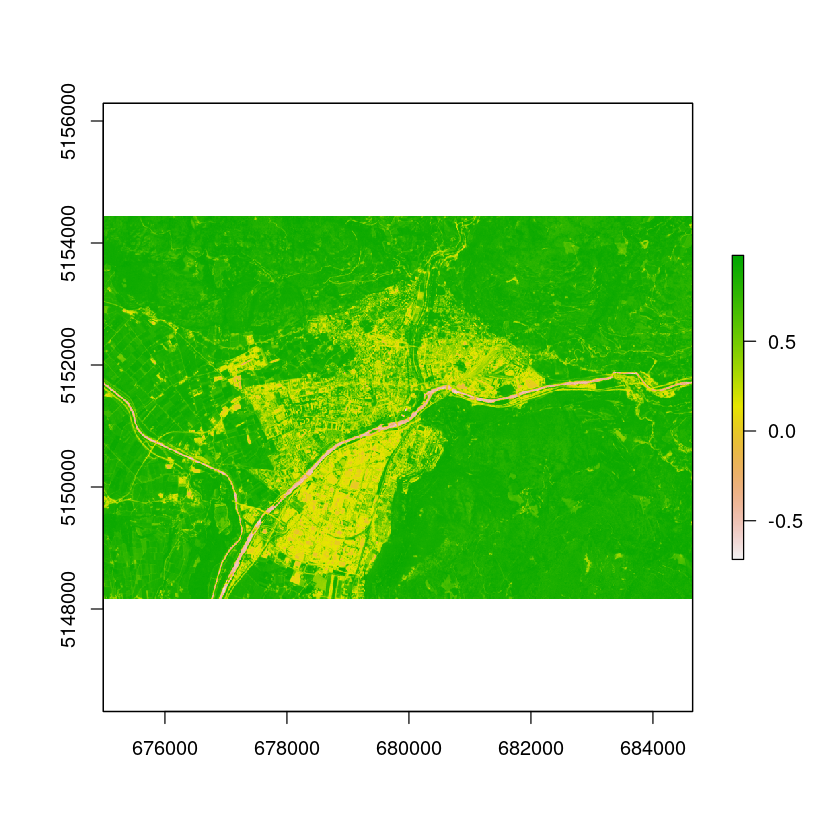

In [12]:
library(raster)
ResultRaster = raster(Result)
plot(ResultRaster)